# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from datetime import datetime

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data
import src.optimization.tf_regularizers as reg


# change the following to %matplotlib notebook for interactive plotting
# %matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 7))
mpl.rc('image', cmap='gray')


# Define some optimization parameters 

In [2]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath = os.path.join('./Data/DROPLETS/RESULTS/', mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

# Define parameters 
is_padding = False 
is_display = True
is_optimization = True 
is_optimization_psf = True
is_flip = False
is_measurement = True

# data files for parameters and measuremets 
if is_measurement:
    matlab_val_file = './Data/DROPLETS/allAmp_pseudotomo.mat'      #'./Data/DROPLETS/allAmp_simu.npy' #
    matlab_par_file = './Data/DROPLETS/myParameter_pseudotomo.mat'   
    matlab_val_name = 'allAmp_tomo'
    matlab_par_name = 'myParameter'  

        
else:
    matlab_val_file = './Data/DROPLETS/RESULTS/allAmp_simu.npy' #'./Data/DROPLETS/allAmp_simu.mat'      
    matlab_par_file = './Data/DROPLETS/myParameterNew.mat' 
    matlab_val_name = 'allAmp_red'
    matlab_par_name = 'myParameterNew'

# microscope parameters
zernikefactors = np.array((0,0,0,0,0,0,0.5,-0.5,0)) # representing the 9 first zernike coefficients in noll-writings 
dn = .05 # refractive index of the object (difference)
NAc = .52
shiftIcY = -1
shiftIcX = -1

'''Define Optimization Parameters'''
my_learningrate = 1e-3  # learning rate
lambda_tv =  1e-3 # lambda for Total variation
epsTV = .1
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 0
lambda_neg = 10

Niter = 1000
Ndisplay = 15


'''START CODE'''
tf.reset_default_graph() # just in case there was an open session

# Generate Test-Object

In [3]:
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname=matlab_par_name)

''' 2.) Read in the parameters of the dataset ''' 
if(matlab_val_file.find('mat')==-1):
    matlab_val = np.load(matlab_val_file)
else:
    matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname=matlab_val_name, is_complex=True)

if(is_flip):
    np_meas_raw = np.flip(matlab_val,0)
    print('Attention: We are flipping the data!')
else:
    np_meas_raw = matlab_val
    print('do we need to flip the data?! -> Observe FFT!!')

''' Create the Model'''
muscat = mus.MuScatModel(matlab_pars, is_optimization=is_optimization, is_optimization_psf = is_optimization_psf)
muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))
muscat.shiftIcY=shiftIcY
muscat.shiftIcX=shiftIcX
muscat.dn = dn
muscat.NAc = NAc
#muscat.dz = muscat.lambdaM/4
#print('Attention: Changed Z-sampling!!')

''' Adjust some parameters to fit it in the memory '''
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=(muscat.dz,muscat.dx,muscat.dy), obj_type ='sphere', diameter = 1, dn = muscat.dn)

# introduce zernike factors here
muscat.zernikefactors = zernikefactors


do we need to flip the data?! -> Observe FFT!!
Assigned some value for dn which is not good!


# Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [4]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True, is_padding=is_padding, is_tomo=True, dropout_prob=1)
print(muscat.Ic.shape)

----------> Be aware: We are taking aberrations into account!
We are weighing the Intensity int the illu-pupil!
Shifting the illumination in X by: -1 Pixel
Shifting the illumination in Y by: -1 Pixel
Number of Illumination Angles / Plane waves: 49
(32, 32)


# Generate Computational Graph (fwd model)

Buildup Q-PHASE Model 
Experimentally using the tomographic scheme!


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:416: ComplexWarning: Casting complex values to real discards the imaginary part
  nparray = values.astype(dtype.as_numpy_dtype)


Only Experimental! Tomographic data?!
----------> Bringing field back to focus


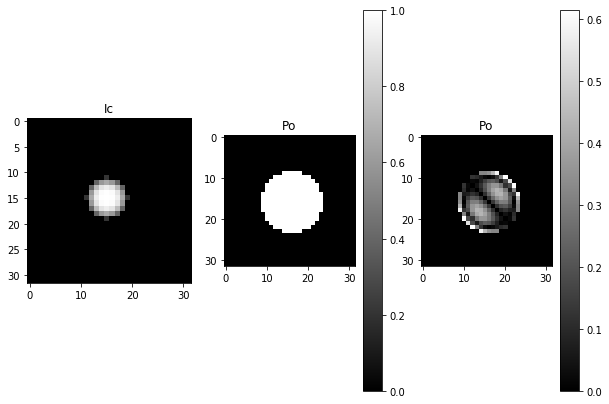

In [5]:
tf_fwd = muscat.computemodel()

if(is_display): 
    plt.subplot(131), plt.title('Ic'), plt.imshow(muscat.Ic)
    plt.subplot(132), plt.title('Po'),plt.imshow(np.fft.fftshift(np.abs(muscat.Po))), plt.colorbar()
    plt.subplot(133), plt.title('Po'),plt.imshow(np.fft.fftshift(np.abs(muscat.myaberration))), plt.colorbar(), plt.show()

# Define Optimizer and Cost-function

Now load data which has been saved previously (Optional!)

Evtl unwrap it!


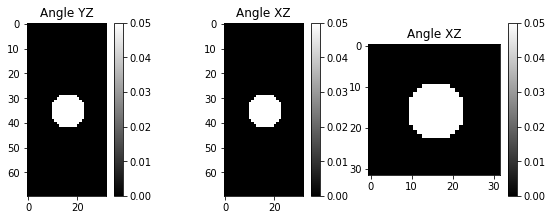

In [6]:
print('Evtl unwrap it!')

# this is the initial guess of the reconstruction
np_meas=np_meas_raw#*np.exp(1j*np.pi)

if(False): # good for the experiment
    init_guess = np.angle(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**2
    init_guess = init_guess/np.max(init_guess)*muscat.dn
elif(False): # good for the simulation
    init_guess = -np.abs(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**2
    init_guess = init_guess/np.max(init_guess)*muscat.dn
    init_guess = np.flip(init_guess,0)
elif(False):
    init_guess = np.ones(np_meas.shape)*muscat.dn
elif(True):
    init_guess = tf_go.generateObject(mysize=muscat.mysize, obj_dim=muscat.dx, obj_type ='sphere', diameter = 7, dn = muscat.dn)
else:
    init_guess = np.random.randn(np_meas.shape[0],init_guess.shape[1],init_guess.shape[2])*muscat.dn

        

if(is_display): plt.subplot(231), plt.title('Angle YZ'),plt.imshow(init_guess[:,init_guess.shape[1]//2,:]), plt.colorbar()
if(is_display): plt.subplot(232), plt.title('Angle XZ'),plt.imshow(init_guess[:,:,init_guess.shape[1]//2]), plt.colorbar()
if(is_display): plt.subplot(233), plt.title('Angle XZ'),plt.imshow(init_guess[init_guess.shape[0]//2,:,:]), plt.colorbar(),plt.show()


#### Optimize

In [7]:
#%%
'''Regression + Regularization'''
tf_meas = tf.placeholder(dtype=tf.complex64, shape=np_meas.shape)
             
'''Define Cost-function'''
tf_lambda_tv = tf.placeholder(tf.float32, [])
tf_tvloss = tf_lambda_tv*reg.tf_total_variation_regularization(muscat.TF_obj_phase, BetaVals = [muscat.dx,muscat.dy,muscat.dz], epsR=epsTV, is_circ = False)  #Alernatively tf_total_variation_regularization # total_variation
#tf_tvloss = tf_lambda_tv*reg.total_variation_iso_conv(muscat.TF_obj_phase,  eps=epsTV, step_sizes = [muscat.dx,muscat.dy,muscat.dz])  #Alernatively tf_total_variation_regularization # total_variation
#tf_tvloss = tf_lambda_tv*10*reg.l1_reg(muscat.TF_obj_phase)
#tf_tvloss = tf_lambda_tv*reg.l2_reg(muscat.TF_obj_phase)

#tf_posloss = lambda_neg*reg.posiminity(muscat.TF_obj_phase, minval=0)
#tf_negloss = lambda_pos*reg.posimaxity(muscat.TF_obj_phase, maxval=.2) 
tf_negsqrloss = lambda_neg*reg.RegularizeNegSqr(muscat.TF_obj_phase)
tf_globalphase = tf.Variable(0., tf.float32, name='var_phase')
tf_globalabs = tf.Variable(1., tf.float32, name='var_abs')# 

tf_fidelity = tf.reduce_sum(tf_helper.tf_abssqr(tf_fwd  - (tf_meas/tf.cast(tf.abs(tf_globalabs), tf.complex64)*tf.exp(1j*tf.cast(tf_globalphase, tf.complex64))))) # allow a global phase parameter to avoid unwrapping effects
tf_loss = tf_fidelity +  tf_negsqrloss + tf_tvloss #tf_negloss + tf_posloss + tf_tvloss

 # data fidelity
# TV regularization
# Positivity Penalty          
# eventually Goods Roughness reg
'''Define Optimizer'''
tf_learningrate = tf.placeholder(tf.float32, []) 
tf_optimizer = tf.train.AdamOptimizer(tf_learningrate)
tf_grads = tf.gradients(tf_loss, [muscat.TF_obj_phase])[0]
#tf_optimizer = tf.train.MomentumOptimizer(tf_learningrate, momentum = .9, use_nesterov=True)

#tf_optimizer = tf.train.ProximalGradientDescentOptimizer(tf_learningrate)
tf_lossop = tf_optimizer.minimize(tf_loss)

    
''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.global_variables_initializer())
if is_optimization:
    if is_padding:
        # Pad object with zeros along X/Y
        init_guess_tmp= np.zeros(muscat.mysize)# + 1j*np.zeros(muscat.mysize)
        init_guess_tmp[:,muscat.Nx//2-muscat.Nx//4:muscat.Nx//2+muscat.Nx//4, muscat.Ny//2-muscat.Ny//4:muscat.Ny//2+muscat.Ny//4] =init_guess
        init_guess = init_guess_tmp

    sess.run(tf.assign(muscat.TF_obj_phase, init_guess)); # assign abs of measurement as initial guess of 

my_fwd = sess.run(tf_fwd)#, feed_dict={muscat.TF_obj:obj})
mysize = my_fwd.shape



# Estimate the Phase difference between Measurement and Simulation

My Init Phase is :0.0183825670925


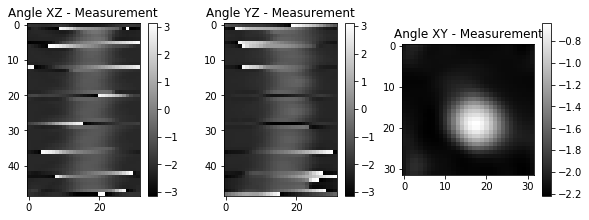

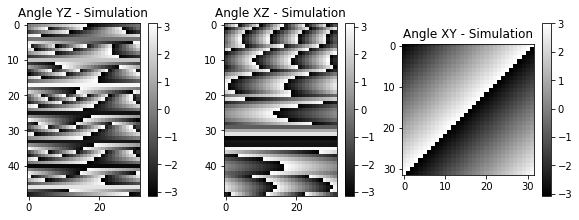

In [8]:
# We assume, that there is a global phase mismatch between measurment and first estimate of the fwd model, this can be estimated by the difference of mean phase of the two
# subtracting the mean phase from either measurement or the fwd model could help to speed up the optimization
# this is the initial guess of the reconstruction
np_meas = matlab_val
myinitphase = np.mean(np.angle(np_meas))-np.mean(np.angle(my_fwd))
print('My Init Phase is :'+str(myinitphase))
np_meas=np_meas*np.exp(-1j*(myinitphase+2)) # subtract globaphase - anyway we want to optimize for that, but now the global phase can be assumed to be 0 initally
if(is_display): plt.subplot(231), plt.title('Angle XZ - Measurement'),plt.imshow(np.angle(np_meas)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('Angle YZ - Measurement'),plt.imshow(np.angle(np_meas)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('Angle XY - Measurement'),plt.imshow(np.angle(np_meas)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

if(is_display): plt.subplot(234), plt.title('Angle YZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY - Simulation'),plt.imshow(np.angle(my_fwd)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

# assert some memory 
iter_last = 0
mylosslist = []
myfidelitylist = []
myposlosslist = []
myneglosslist = []
mytvlosslist = []
result_phaselist = []
result_reallist = []
globalphaselist = []
globalabslist = []

Start optimizing
Loss@0: 58828.3 - Fid: 55239.0, Neg: 0.0, TV: 3589.27 G-Phase:0.0 G-ABS: 1.0


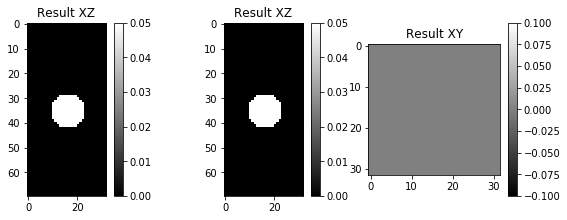

Loss@15: 44137.6 - Fid: 43913.2, Neg: 0.0, TV: 224.335 G-Phase:0.0140545 G-ABS: 1.01397


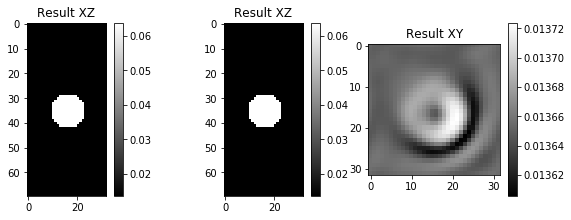

Loss@30: 37388.1 - Fid: 37272.3, Neg: 0.0, TV: 115.792 G-Phase:0.0282746 G-ABS: 1.02779


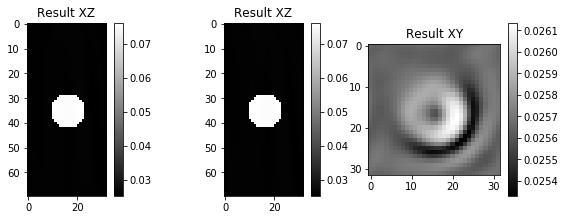

Loss@45: 33360.4 - Fid: 33282.4, Neg: 0.0, TV: 78.0388 G-Phase:0.0426213 G-ABS: 1.04138


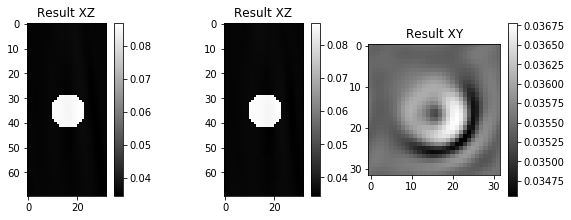

Loss@60: 30734.8 - Fid: 30676.0, Neg: 0.0, TV: 58.8539 G-Phase:0.0570576 G-ABS: 1.05471


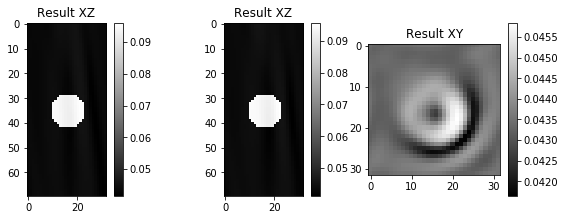

Loss@75: 28855.2 - Fid: 28808.0, Neg: 0.0, TV: 47.2436 G-Phase:0.0715842 G-ABS: 1.06778


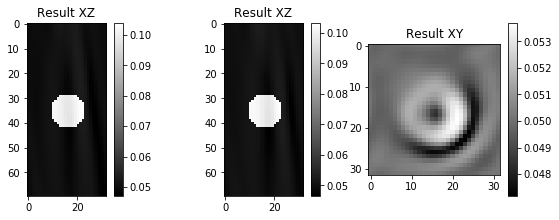

Loss@90: 27403.9 - Fid: 27364.4, Neg: 0.0, TV: 39.4624 G-Phase:0.0862107 G-ABS: 1.0806


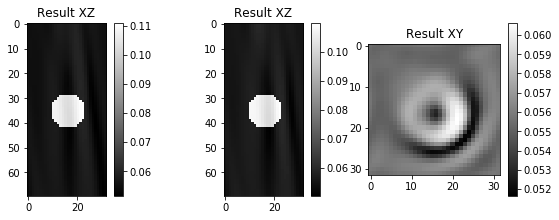

Loss@105: 26220.8 - Fid: 26186.9, Neg: 0.0, TV: 33.8851 G-Phase:0.100939 G-ABS: 1.09319


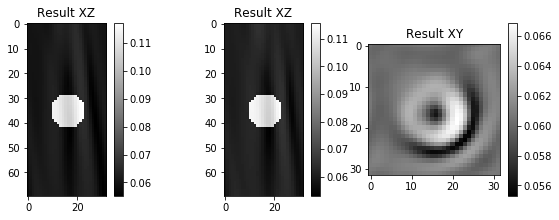

Loss@120: 25219.2 - Fid: 25189.5, Neg: 0.0, TV: 29.6922 G-Phase:0.11576 G-ABS: 1.10555


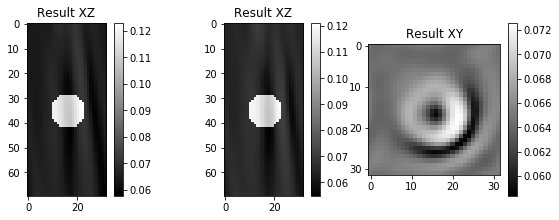

Loss@135: 24348.3 - Fid: 24321.8, Neg: 0.0, TV: 26.4258 G-Phase:0.130661 G-ABS: 1.1177


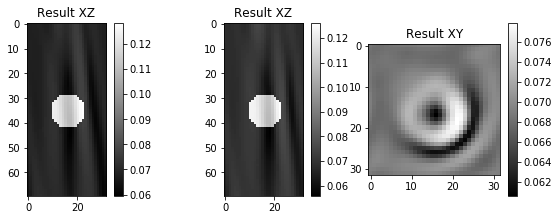

Loss@150: 23575.8 - Fid: 23552.0, Neg: 0.0, TV: 23.8097 G-Phase:0.145625 G-ABS: 1.12965


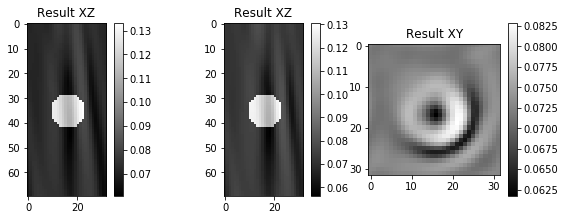

Loss@165: 22880.4 - Fid: 22858.7, Neg: 0.0, TV: 21.6679 G-Phase:0.160636 G-ABS: 1.14142


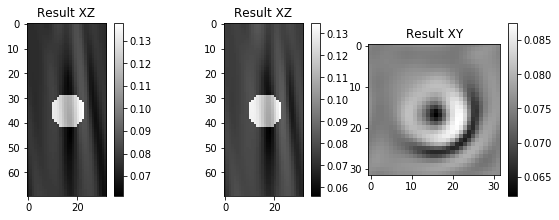

Loss@180: 22247.0 - Fid: 22227.2, Neg: 0.0, TV: 19.8824 G-Phase:0.175679 G-ABS: 1.153


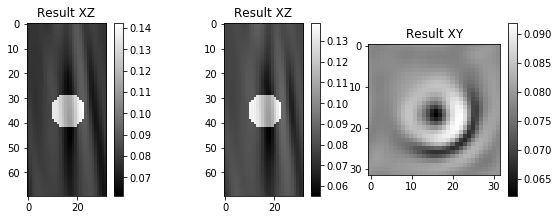

Loss@195: 21664.8 - Fid: 21646.5, Neg: 0.0, TV: 18.3716 G-Phase:0.190738 G-ABS: 1.1644


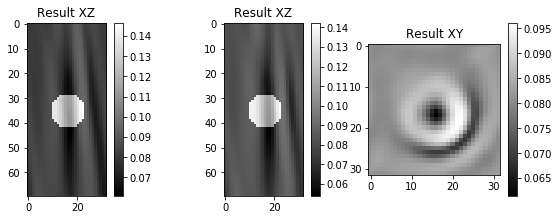

Loss@210: 21125.6 - Fid: 21108.5, Neg: 0.0, TV: 17.077 G-Phase:0.205801 G-ABS: 1.17564


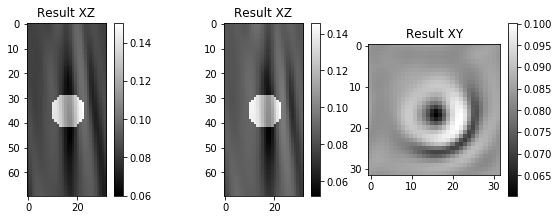

Loss@225: 20622.9 - Fid: 20607.0, Neg: 0.0, TV: 15.9557 G-Phase:0.220856 G-ABS: 1.18673


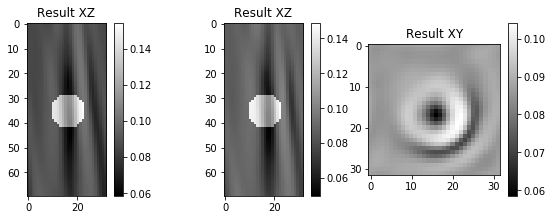

Loss@240: 20151.9 - Fid: 20137.0, Neg: 0.0, TV: 14.9754 G-Phase:0.235892 G-ABS: 1.19766


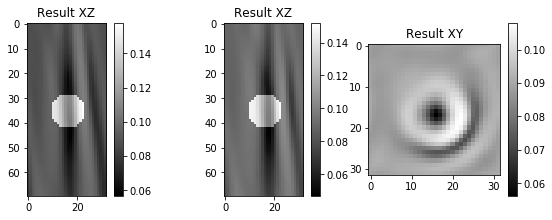

Loss@255: 19708.6 - Fid: 19694.5, Neg: 0.0, TV: 14.1115 G-Phase:0.250897 G-ABS: 1.20844


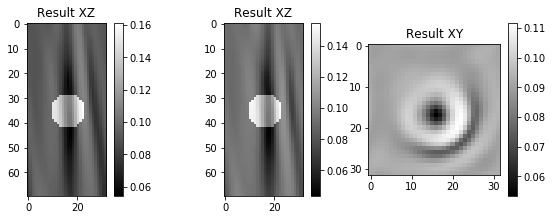

Loss@270: 19289.6 - Fid: 19276.3, Neg: 0.0, TV: 13.3448 G-Phase:0.265861 G-ABS: 1.21908


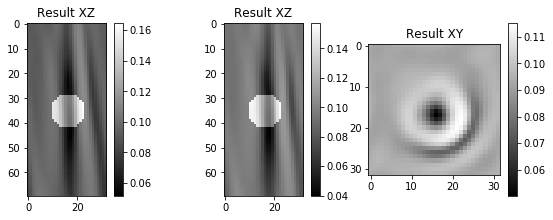

Loss@285: 18892.3 - Fid: 18879.6, Neg: 0.0, TV: 12.6601 G-Phase:0.28077 G-ABS: 1.22958


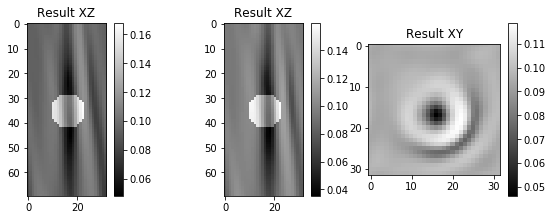

Loss@300: 18514.2 - Fid: 18502.2, Neg: 0.0, TV: 12.0453 G-Phase:0.295613 G-ABS: 1.23996


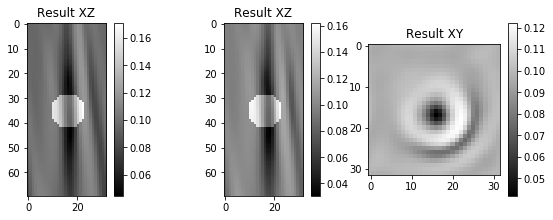

Loss@315: 18153.6 - Fid: 18142.1, Neg: 0.0, TV: 11.4907 G-Phase:0.310372 G-ABS: 1.25021


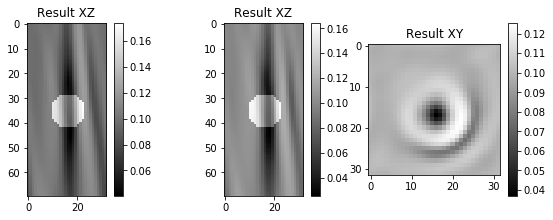

Loss@330: 17808.5 - Fid: 17797.5, Neg: 0.0, TV: 10.9882 G-Phase:0.32503 G-ABS: 1.26033


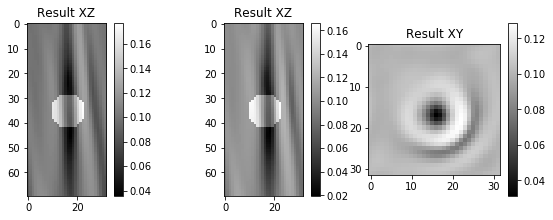

Loss@345: 17477.6 - Fid: 17467.0, Neg: 0.0, TV: 10.5313 G-Phase:0.339564 G-ABS: 1.27034


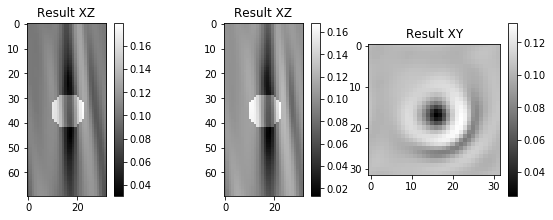

Loss@360: 17159.4 - Fid: 17149.3, Neg: 1.00472e-06, TV: 10.1145 G-Phase:0.353945 G-ABS: 1.28023


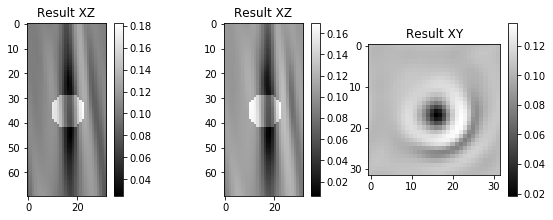

Loss@375: 16852.8 - Fid: 16843.0, Neg: 0.00294119, TV: 9.73317 G-Phase:0.368135 G-ABS: 1.29001


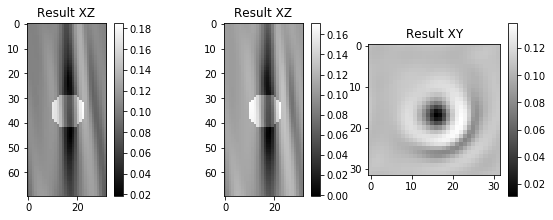

Loss@390: 16556.6 - Fid: 16547.2, Neg: 0.0207639, TV: 9.38344 G-Phase:0.382089 G-ABS: 1.29969


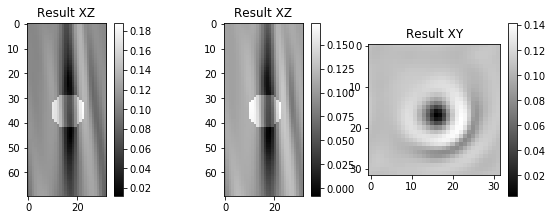

Loss@405: 16269.8 - Fid: 16260.7, Neg: 0.0695903, TV: 9.06198 G-Phase:0.395746 G-ABS: 1.30925


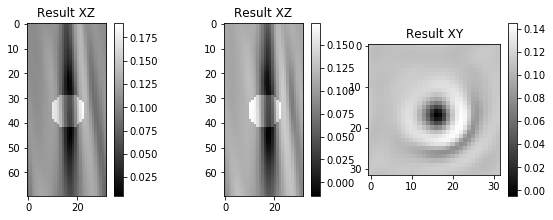

Loss@420: 15991.7 - Fid: 15982.7, Neg: 0.183078, TV: 8.7659 G-Phase:0.409031 G-ABS: 1.31872


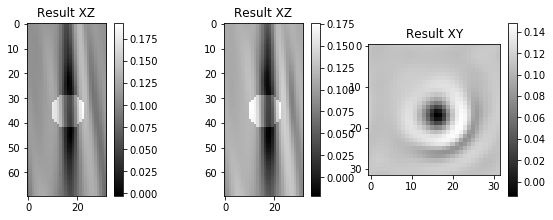

Loss@435: 15721.3 - Fid: 15712.4, Neg: 0.39744, TV: 8.49268 G-Phase:0.421846 G-ABS: 1.32808


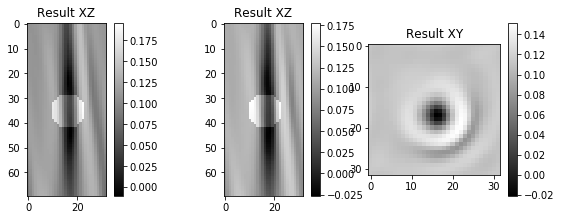

Loss@450: 15457.9 - Fid: 15448.9, Neg: 0.757078, TV: 8.24013 G-Phase:0.43407 G-ABS: 1.33735


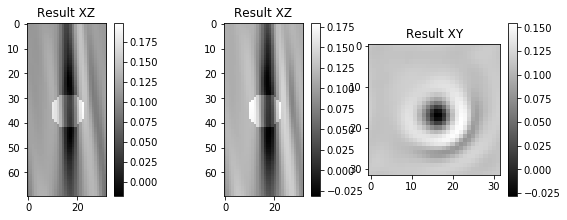

Loss@465: 15201.0 - Fid: 15191.6, Neg: 1.31721, TV: 8.00629 G-Phase:0.445556 G-ABS: 1.34652


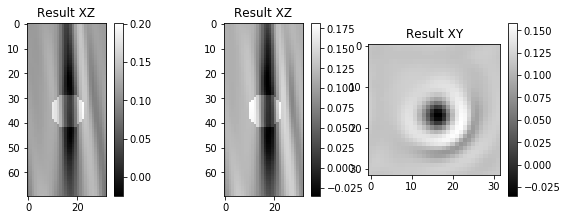

Loss@480: 14949.9 - Fid: 14939.9, Neg: 2.14676, TV: 7.78945 G-Phase:0.456126 G-ABS: 1.35559


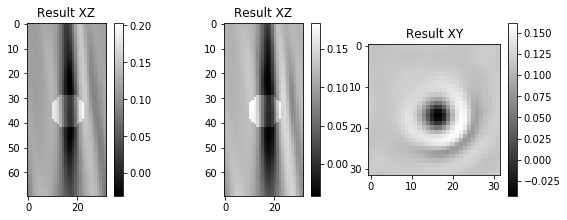

Loss@495: 14704.2 - Fid: 14693.3, Neg: 3.31204, TV: 7.58805 G-Phase:0.46558 G-ABS: 1.36458


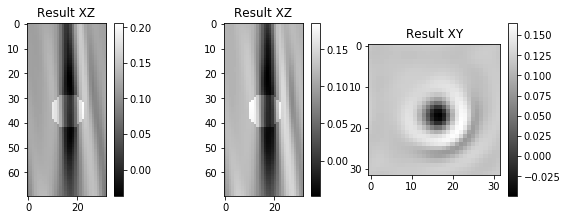

Loss@510: 14463.5 - Fid: 14451.2, Neg: 4.90085, TV: 7.40075 G-Phase:0.473702 G-ABS: 1.37346


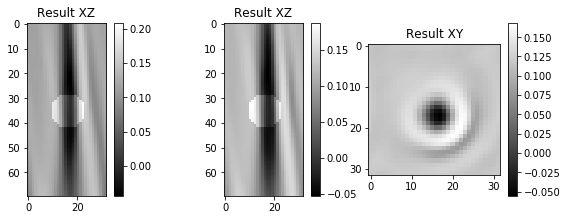

Loss@525: 14227.3 - Fid: 14213.1, Neg: 6.99176, TV: 7.22642 G-Phase:0.480284 G-ABS: 1.38226


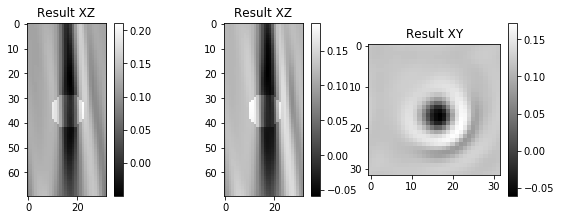

Loss@540: 13995.3 - Fid: 13978.6, Neg: 9.6379, TV: 7.06413 G-Phase:0.485151 G-ABS: 1.39096


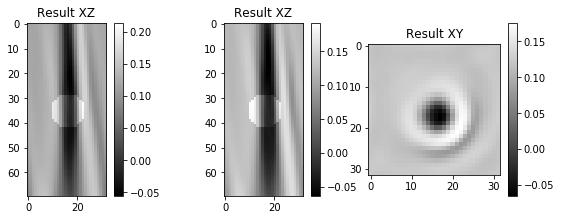

Loss@555: 13766.9 - Fid: 13747.2, Neg: 12.8637, TV: 6.91318 G-Phase:0.488204 G-ABS: 1.39957


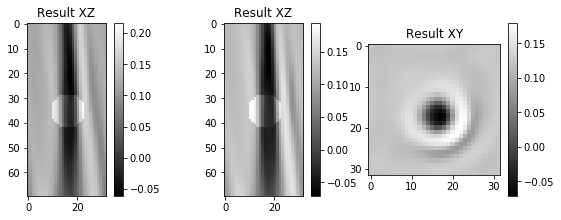

Loss@570: 13541.8 - Fid: 13518.3, Neg: 16.7186, TV: 6.77307 G-Phase:0.489445 G-ABS: 1.40808


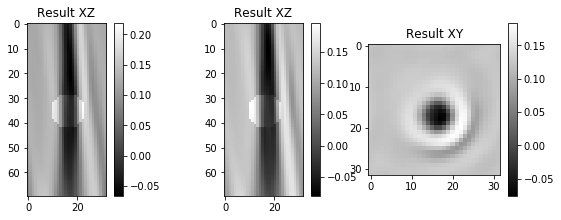

Loss@585: 13319.8 - Fid: 13291.8, Neg: 21.3247, TV: 6.64335 G-Phase:0.489 G-ABS: 1.4165


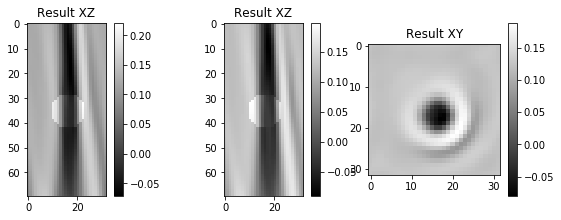

Loss@600: 13101.1 - Fid: 13067.8, Neg: 26.83, TV: 6.52351 G-Phase:0.487116 G-ABS: 1.42483


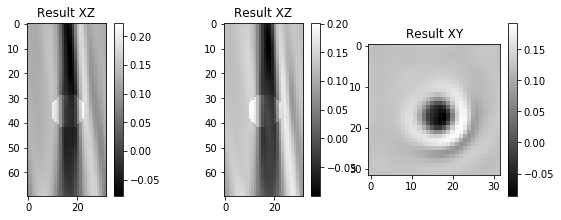

Loss@615: 12886.5 - Fid: 12846.7, Neg: 33.3734, TV: 6.41288 G-Phase:0.484142 G-ABS: 1.43306


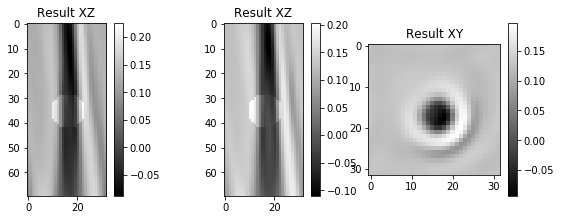

Loss@630: 12676.9 - Fid: 12629.6, Neg: 40.9838, TV: 6.31062 G-Phase:0.480494 G-ABS: 1.4412


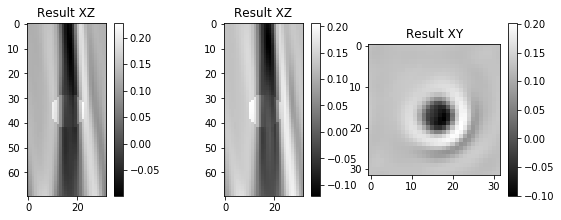

Loss@645: 12473.2 - Fid: 12417.5, Neg: 49.5345, TV: 6.21579 G-Phase:0.476601 G-ABS: 1.44923


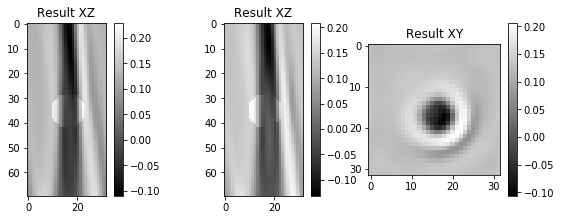

Loss@660: 12276.0 - Fid: 12211.1, Neg: 58.7456, TV: 6.12748 G-Phase:0.472856 G-ABS: 1.45718


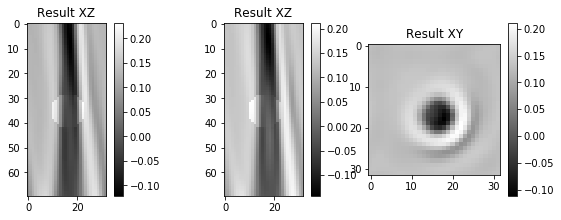

Loss@675: 12085.6 - Fid: 12011.3, Neg: 68.3024, TV: 6.04485 G-Phase:0.469552 G-ABS: 1.46503


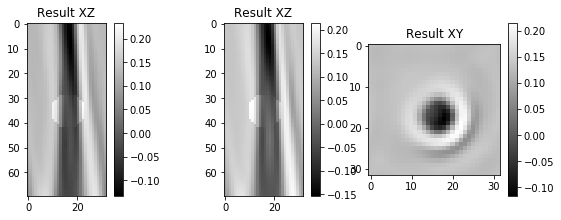

Loss@690: 11902.1 - Fid: 11818.2, Neg: 77.9318, TV: 5.96724 G-Phase:0.466849 G-ABS: 1.47279


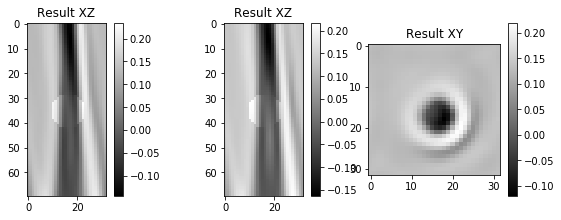

Loss@705: 11725.0 - Fid: 11631.7, Neg: 87.4135, TV: 5.8941 G-Phase:0.464751 G-ABS: 1.48046


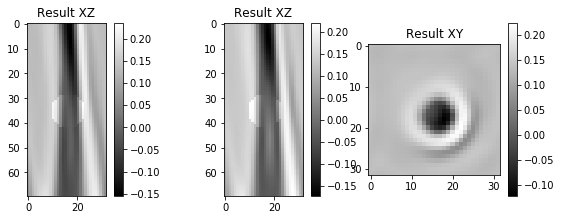

Loss@720: 11554.1 - Fid: 11451.7, Neg: 96.6294, TV: 5.82499 G-Phase:0.46313 G-ABS: 1.48805


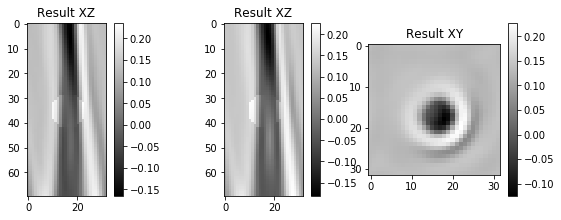

Loss@735: 11388.9 - Fid: 11277.6, Neg: 105.551, TV: 5.75959 G-Phase:0.461778 G-ABS: 1.49556


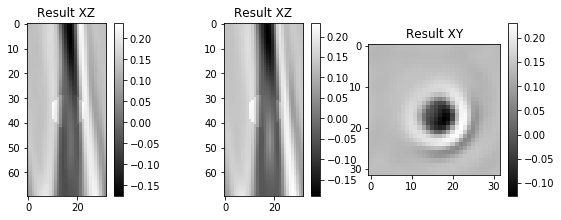

Loss@750: 11229.1 - Fid: 11109.2, Neg: 114.181, TV: 5.69765 G-Phase:0.460477 G-ABS: 1.50299


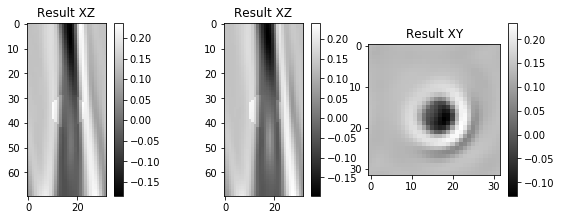

Loss@765: 11074.3 - Fid: 10946.1, Neg: 122.524, TV: 5.63893 G-Phase:0.459052 G-ABS: 1.51036


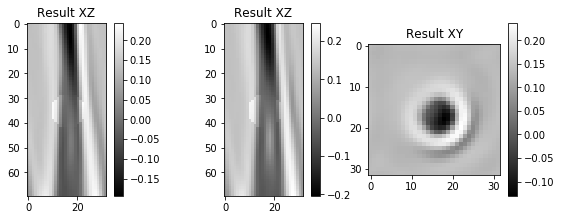

Loss@780: 10924.1 - Fid: 10787.9, Neg: 130.576, TV: 5.58327 G-Phase:0.457398 G-ABS: 1.51765


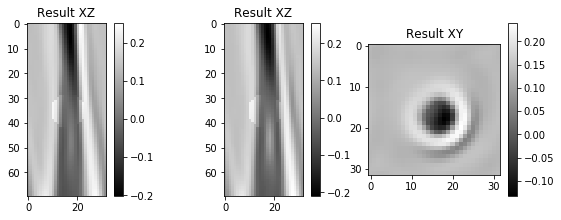

Loss@795: 10778.1 - Fid: 10634.2, Neg: 138.353, TV: 5.53052 G-Phase:0.455466 G-ABS: 1.52489


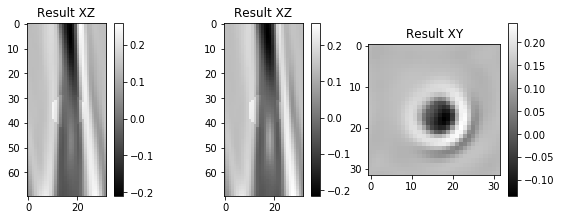

Loss@810: 10636.0 - Fid: 10484.7, Neg: 145.866, TV: 5.48055 G-Phase:0.453245 G-ABS: 1.53205


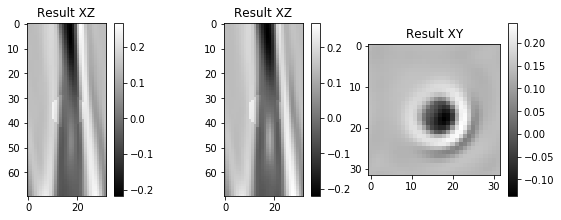

Loss@825: 10497.6 - Fid: 10339.0, Neg: 153.133, TV: 5.43326 G-Phase:0.450747 G-ABS: 1.53916


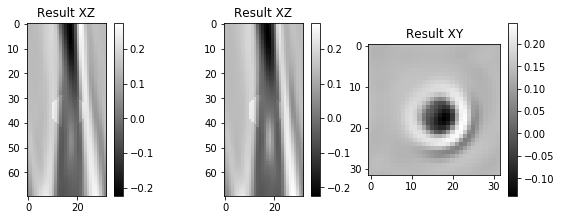

Loss@840: 10362.4 - Fid: 10196.9, Neg: 160.181, TV: 5.38856 G-Phase:0.447989 G-ABS: 1.54621


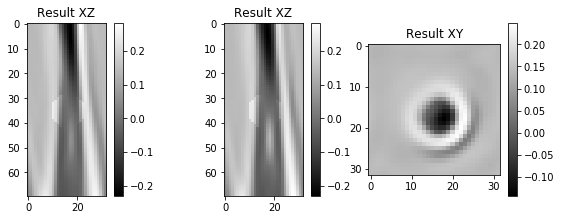

Loss@855: 10230.4 - Fid: 10058.0, Neg: 167.039, TV: 5.34636 G-Phase:0.444988 G-ABS: 1.5532


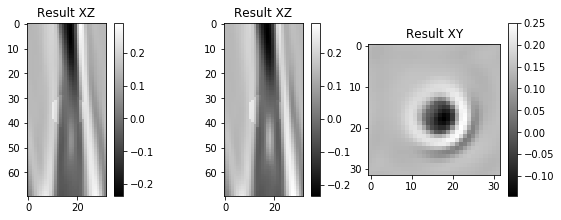

Loss@870: 10101.2 - Fid: 9922.15, Neg: 173.75, TV: 5.30657 G-Phase:0.441758 G-ABS: 1.56013


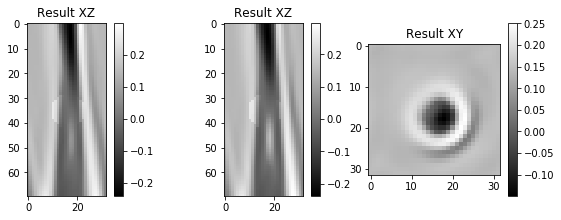

Loss@885: 9974.74 - Fid: 9789.1, Neg: 180.37, TV: 5.26903 G-Phase:0.438315 G-ABS: 1.56701


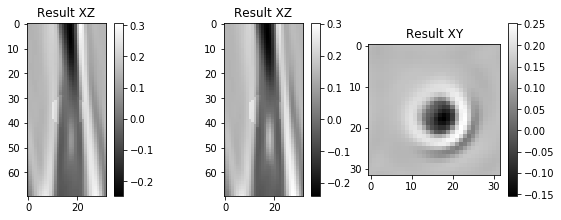

Loss@900: 9850.86 - Fid: 9658.69, Neg: 186.943, TV: 5.23359 G-Phase:0.434671 G-ABS: 1.57384


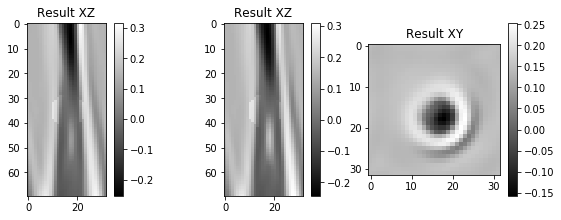

Loss@915: 9729.43 - Fid: 9530.72, Neg: 193.508, TV: 5.20011 G-Phase:0.430836 G-ABS: 1.58061


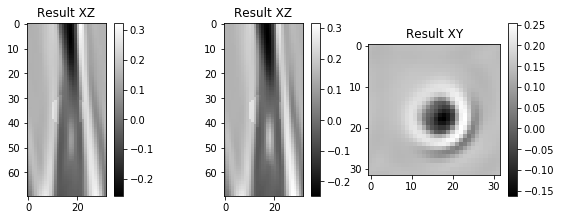

Loss@930: 9610.31 - Fid: 9405.04, Neg: 200.105, TV: 5.16842 G-Phase:0.426823 G-ABS: 1.58733


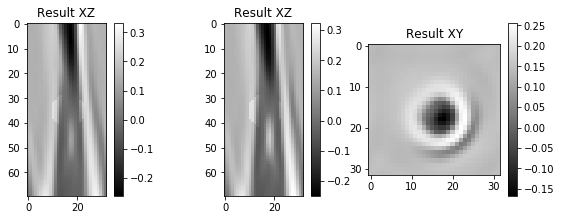

Loss@945: 9493.42 - Fid: 9281.5, Neg: 206.778, TV: 5.1384 G-Phase:0.422644 G-ABS: 1.594


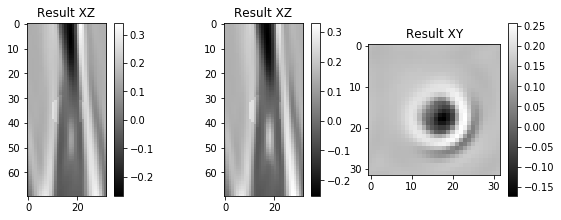

Loss@960: 9378.67 - Fid: 9159.99, Neg: 213.566, TV: 5.10988 G-Phase:0.418314 G-ABS: 1.60062


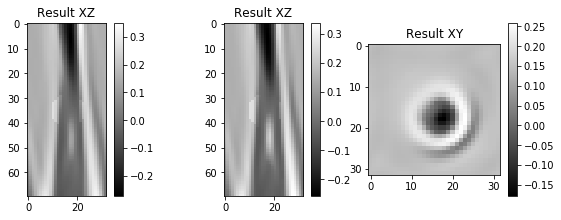

Loss@975: 9265.94 - Fid: 9040.37, Neg: 220.492, TV: 5.08278 G-Phase:0.413847 G-ABS: 1.60718


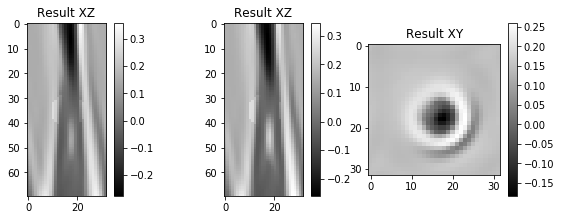

Loss@990: 9155.14 - Fid: 8922.51, Neg: 227.57, TV: 5.05703 G-Phase:0.409256 G-ABS: 1.6137


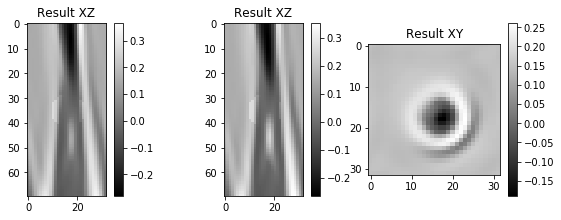

In [9]:
#%%
''' Optimize the model '''
print('Start optimizing')
np_meas = matlab_val # use the previously simulated data
for iterx in range(iter_last,Niter):
    if iterx == 1000:
        my_learningrate = my_learningrate#*.1
    # try to optimize
    mylambdatv = lambda_tv/((iterx+1)/100)
    if(iterx==0 or not np.mod(iterx, Ndisplay)):
        my_res_phase, my_loss, my_fidelity, my_negloss, my_tvloss, myglobalphase, myglobalabs, myfwd =  \
            sess.run([muscat.TF_obj_phase, tf_loss, tf_fidelity, tf_negsqrloss, tf_tvloss, tf_globalphase, tf_globalabs, tf_fwd], \
                     feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate, tf_lambda_tv:mylambdatv})

        print('Loss@'+str(iterx)+': ' + str(my_loss) + ' - Fid: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', TV: '+str(my_tvloss)+' G-Phase:'+str(myglobalphase)+' G-ABS: '+str(myglobalabs))        
        mylosslist.append(my_loss)
        myfidelitylist.append(my_fidelity)
        myneglosslist.append(my_negloss)
        mytvlosslist.append(my_tvloss)
        result_phaselist.append(my_res_phase)
        globalphaselist.append(myglobalphase)
        globalabslist.append(myglobalabs)  
        
        if(True):
            if(is_display): plt.subplot(234), plt.title('Result XZ'),plt.imshow((my_res_phase)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(235), plt.title('Result XZ'),plt.imshow((my_res_phase)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(236), plt.title('Result XY'),plt.imshow((my_res_phase)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

        if(False):
            if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

    else:
        _, mygrads = sess.run([tf_lossop,tf_grads], feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate, tf_lambda_tv:mylambdatv})
        #plt.imshow(np.abs(my_res[:,50,:]))
        #print(mygrads)
        #print(mygrads.shape)
        if(False):
            if(is_display): plt.subplot(231), plt.title('Grad XZ'),plt.imshow(np.angle(myfwd)[:,mygrads.shape[1]//2,:]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(232), plt.title('Grad XZ'),plt.imshow(np.angle(myfwd)[:,:,mygrads.shape[2]//2]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(233), plt.title('Grad XY'),plt.imshow(np.angle(myfwd)[mygrads.shape[0]//2,:,:]), plt.colorbar(), plt.show()

            if(is_display): plt.subplot(234), plt.title('Grad XZ'),plt.imshow(np.abs(myfwd)[:,mygrads.shape[1]//2,:]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(235), plt.title('Grad XZ'),plt.imshow(np.abs(myfwd)[:,:,mygrads.shape[2]//2]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(236), plt.title('Grad XY'),plt.imshow(np.abs(myfwd)[mygrads.shape[0]//2,:,:]), plt.colorbar(), plt.show()

        

#save stack to disk
#sktiff.imsave(savepath+'Obj_Reconstruction.tif', np.array(resultlist), compress=6, metadata={'axes': 'TZXY'})

# Display result - FFT

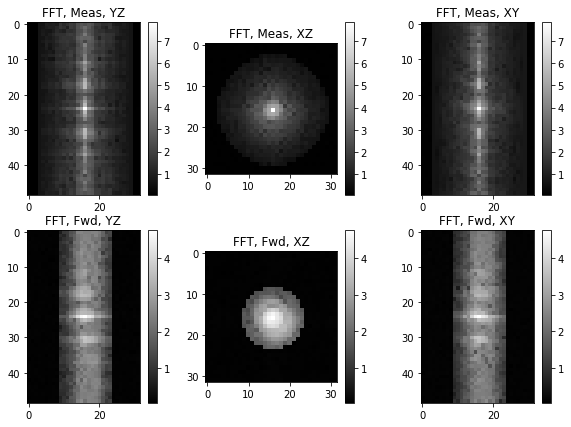

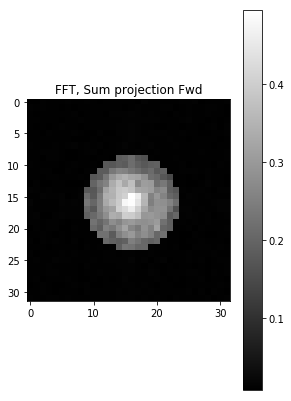

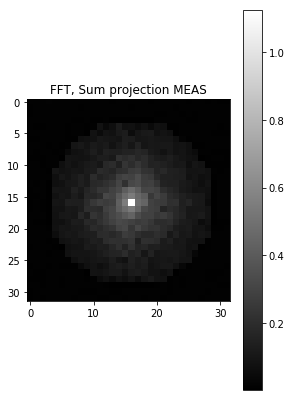

In [10]:
iter_last = iterx
#%% Display the results
is_display=True
myfwd, mymeas, my_res_phase = sess.run([tf_fwd, tf_meas, muscat.TF_obj_phase], feed_dict={tf_meas:np_meas})
        
if(is_display): plt.subplot(231),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(np_meas))**.2)[:,mymeas.shape[1]//2,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(232),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[mymeas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()   
if(is_display): plt.subplot(233),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,:,mymeas.shape[2]//2]), plt.colorbar()#, plt.show()     
if(is_display): plt.subplot(234),plt.title('FFT, Fwd, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235),plt.title('FFT, Fwd, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(236),plt.title('FFT, Fwd, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show() 
plt.savefig(savepath+'/res_ffts.png'), plt.show()

    
if(is_display): plt.subplot(121), plt.title('FFT, Sum projection Fwd'), plt.imshow(np.std(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2),0)), plt.colorbar(), plt.show()    
if(is_display): plt.subplot(121), plt.title('FFT, Sum projection MEAS'), plt.imshow(np.std(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2),0)), plt.colorbar(), plt.show()    


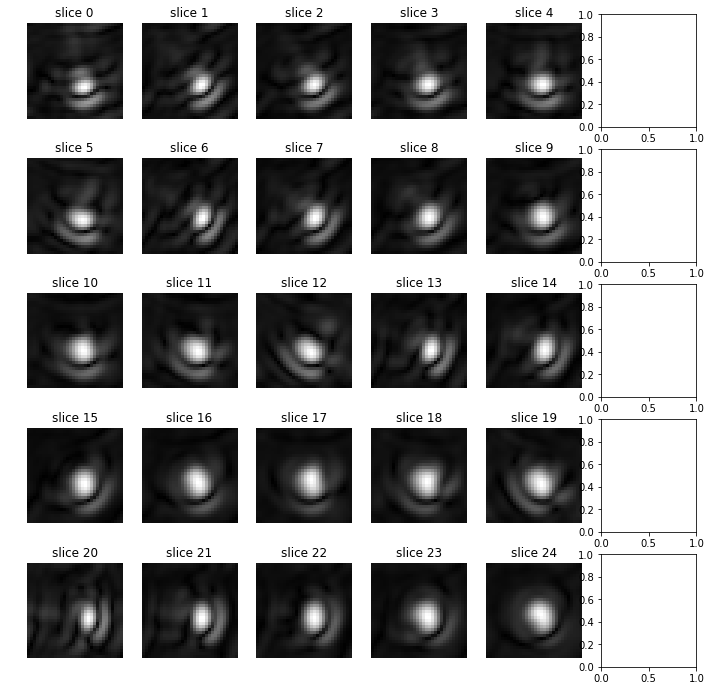

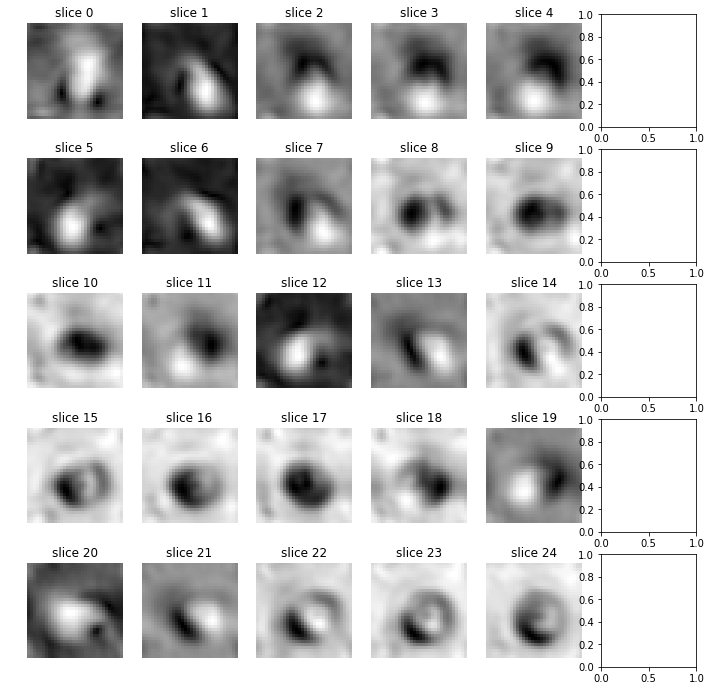

(49, 32, 32)


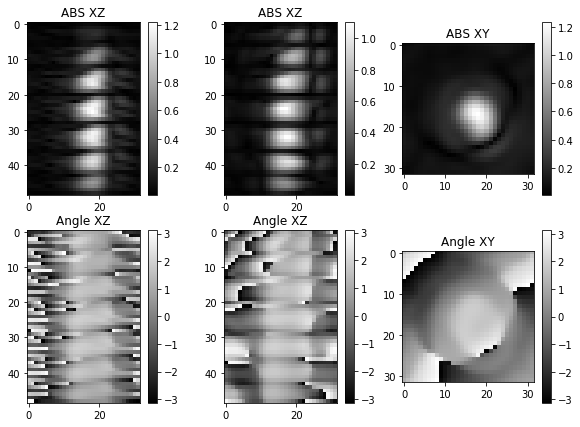

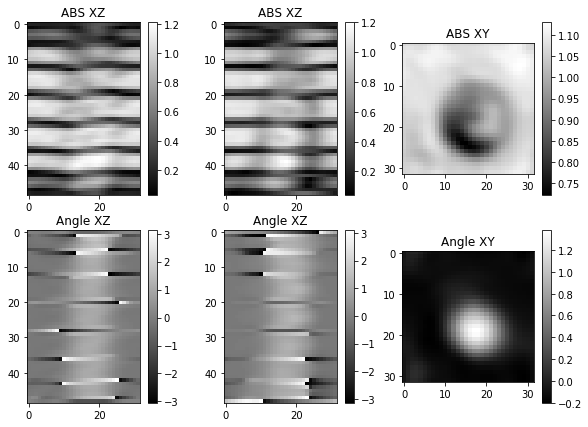

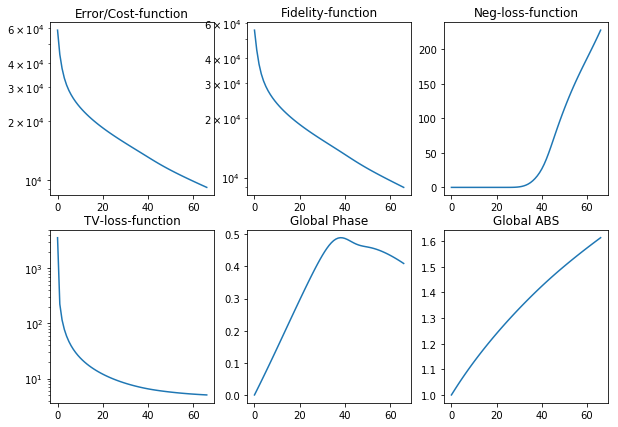

In [14]:
# This is the reconstruction

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        try:
            ind = start_with + i*show_every
            myimage=stack[ind]           
            ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
            ax[int(i/rows),int(i % rows)].imshow(myimage,cmap='gray')
            ax[int(i/rows),int(i % rows)].axis('off')
        except IndexError:
            break
    plt.show()

sample_stack(np.abs(myfwd),5,6,0,1)
sample_stack(np.abs(np_meas),5,6,0,1)
print(myfwd.shape)

if(is_display): 
    plt.figure()
    plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()
    plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()
    plt.savefig(savepath+'/res_myfwd.png'), plt.show()

    # This is the measurment
    plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()
    plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()
    plt.savefig(savepath+'/res_mymeas.png'), plt.show()

    # diplay the error over time
    plt.subplot(231), plt.title('Error/Cost-function'), plt.semilogy((np.array(mylosslist)))#, plt.show()
    plt.subplot(232), plt.title('Fidelity-function'), plt.semilogy((np.array(myfidelitylist)))#, plt.show()
    plt.subplot(233), plt.title('Neg-loss-function'), plt.plot(np.array(myneglosslist))#, plt.show()
    plt.subplot(234), plt.title('TV-loss-function'), plt.semilogy(np.array(mytvlosslist))#, plt.show()
    plt.subplot(235), plt.title('Global Phase'), plt.plot(np.array(globalphaselist))#, plt.show()
    plt.subplot(236), plt.title('Global ABS'), plt.plot(np.array(globalabslist))#, plt.show()
    plt.savefig(savepath+'/myplots.png'), plt.show()

# Display Result Refractive index

# Display results ABS/Angle - FWD model

In [ ]:
if(is_display): 
    plt.subplot(131), plt.title('Result Phase: XZ'),plt.imshow(my_res_phase[:,my_res_phase.shape[1]//2,:]), plt.colorbar()#, plt.show()
    plt.subplot(132), plt.title('Result Phase: XZ'),plt.imshow(my_res_phase[:,:,my_res_phase.shape[2]//2]), plt.colorbar()#, plt.show()
    plt.subplot(133), plt.title('Result Phase: XY'),plt.imshow(my_res_phase[my_res_phase.shape[0]//2,:,:]), plt.colorbar()
    plt.savefig(savepath+'/RI_result.png'), plt.show()
    
    print(np.real(sess.run(muscat.TF_zernikefactors)))
    plt.subplot(121), plt.title('Po Phase'), plt.imshow(np.fft.fftshift(np.angle(sess.run(muscat.TF_Po_aberr)))), plt.colorbar()
    plt.subplot(122), plt.title('Po abs'), plt.imshow(np.fft.fftshift(np.abs(sess.run(muscat.TF_Po_aberr)))), plt.colorbar()
    plt.savefig(savepath+'/recovered_pupil.png'), plt.show()

    data.export_realdatastack_h5(savepath+'/myrefractiveindex.h5', 'temp', np.array(result_phaselist))